# Playground: Backtesting the Turning Point Strategy

Now that we've developed our algotrading strategy, we need to backtest it against historical data to see if it is actually worth implementing - what we're going to be looking for is whether on average it beats a simple buy-and-hold strategy.

## Import Libraries

In [40]:
import matplotlib.pyplot as plt

from datetime import date, datetime
import pandas as pd
import os
from tradingFuncs import getStratData, tradeStrategy, getDataArgs, getStratResults, evaluateSVRStrat

# For backtrader use
from sklearn import svm

from modelFuncs import getHistoricalIntradayResponse, getFeaturesAndTargets, getFeatures

from tqdm import tqdm
import time
import numpy as np
from itertools import chain
import seaborn as sns

## Prepare Backtesting Data

### Load data from API

Here we're using a custom function to retrieve stock ticker data using the stockdata.org API. We feed in the start and end dates, the trading symbol of the stock we want to retrieve data for, and the interval. We're going to retrieve minute-level trading data for Microsoft from June 2020 through to June 2022.

Why minute level? The authors of the preprint this work is [based on](https://arxiv.org/abs/1209.0127) suggest that this sort of strategy will work better for intra-day approaches, so we're going to put that to the test. It's a rogue move given in our previous notebook we saw our strategy outperformed a buy-and-hold strategy on daily data, but let's try it anyway.

We are going to check for pre-existing csv's of this data as the free tier of the stockdata.org API has a request limit per day, so here we only request data if we don't already have it.

In [44]:
# Retrieve minute level bars for our chosen ticket symbol between the dates specified
startDate = date(2018,6,10)
endDate = date(2022,6,10)
symbolFirst = 'MSFT'
intervalFirst = 'day'

# If the user wants per minute prices, each request gets 7 days of data, so create
# a list of dates to retrieve where each is separated by 8 days
if intervalFirst == 'minute':
    frequency = '8d'
    
# For hour, this is 180 days, so separate by 181d
elif intervalFirst == 'hour':
    frequency = '181d'

# For day this seems to be 919 days, so add one (need to check docs though)
elif intervalFirst == 'day':
    frequency = '920d'

# Create our date range
dateRange = pd.date_range(startDate, endDate, freq=frequency)

dateRangePrint = [d.strftime('%Y-%m-%d') for d in dateRange]
dateRangePrint.append(endDate.strftime('%Y-%m-%d'))

# Compute our start and end dates in a printing friendly format
startDatePrint = min(dateRangePrint)
endDatePrint = max(dateRangePrint)

folder = f'{symbolFirst}_{startDatePrint}_{endDatePrint}_{intervalFirst}_historical_intraday'

# If the folder doesn't exist, make it
if not os.path.exists(folder):
    print('Made folder')
    os.mkdir(folder)

# For each date to query the API for
for printDate in dateRangePrint:
    
    # Generate a file path for what we would save the data as
    currentDate = datetime.strptime(printDate, '%Y-%m-%d')
    title = (f'{symbolFirst}_{printDate}_{intervalFirst}_historical_intraday.csv')
    savePath = os.path.join(folder, title)
    
    # If we haven't already saved that data
    if not os.path.exists(savePath):

        print('Retrieving data')

        data = getHistoricalIntradayResponse(symbolFirst, intervalFirst, currentDate)

        data.to_csv(savePath)

Retrieving data
Retrieving data
Retrieving data


Here we are creating a folder where we can save the results of our backtesting, and then reading in all our backtesting data and turning it into a single dataframe.

In [58]:
# Create a folder path for saving our data
resultsFolder = folder + '_results'

# If the folder doesn't exist, make it
if not os.path.exists(resultsFolder):
    print('Made folder')
    os.mkdir(resultsFolder)

# For each .csv file saved for our data, read it back and concatenate them all into a single pd dataframe

if intervalFirst in ['day']:

    outDfRaw = pd.concat(
        [
            pd.read_csv(f'{folder}/'+x) for x in os.listdir(f'{folder}')
        ]
    )

    outDfRaw.index = pd.to_datetime(outDfRaw['date'])

else:


    outDfRaw = pd.concat(
        [
            pd.read_csv(f'{folder}/'+str(x), index_col = 'date') for x in os.listdir(f'{folder}')
        ]
    )

outDfRaw = outDfRaw.loc[startDatePrint:endDatePrint]
outDfRaw.drop_duplicates(inplace = True, keep = 'first')
outDfRaw.head()

<ipython-input-58-2ec774018c6e>:30: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  outDfRaw = outDfRaw.loc[startDatePrint:endDatePrint]


,Unnamed: 0,date,ticker,data.open,data.high,data.low,data.close,data.volume,data.is_extended_hours
date,,,,,,,,,
2020-12-16 00:00:00+00:00,0,2020-12-16T00:00:00.000Z,MSFT,214.88,220.11,214.77,219.08,656629.0,False
2020-12-15 00:00:00+00:00,1,2020-12-15T00:00:00.000Z,MSFT,215.17,215.32,212.26,214.12,1190303.0,False
2020-12-14 00:00:00+00:00,2,2020-12-14T00:00:00.000Z,MSFT,212.99,216.20,212.94,214.16,800326.0,False
2020-12-11 00:00:00+00:00,3,2020-12-11T00:00:00.000Z,MSFT,209.94,213.30,209.12,213.24,603393.0,False
2020-12-10 00:00:00+00:00,4,2020-12-10T00:00:00.000Z,MSFT,211.64,213.03,210.37,210.51,591532.0,False


### Format Date

Here we are going to format our data - firstly by setting the index and changing some column names.

In [59]:
# Drop and rename columns
outDfRaw.drop(columns = ['Unnamed: 0', 'ticker', 'data.is_extended_hours'], inplace = True, )
outDfRaw.rename(columns = {
    'data.open':'Open', 
    'data.high': 'High', 
    'data.low': 'Low', 
    'data.close': 'Close', 
    'data.volume': 'Volume'
}, inplace = True)

# Format the index to a datetime object, rename it, sort our dataframe by it
outDfRaw.index.names = ['Date']
outDfRaw.index = pd.to_datetime(outDfRaw.index)
outDfRaw.sort_values(by = 'Date', inplace = True)

Now here, to ensure consistency between the batches of dates we're using to evaluate our strategy, we want to make sure we bound our data by the start and end of the working week, as we know there is weekly seasonality in trading prices and activity. We then ensure we are removing any days from our dataset that aren't weekdays, and create a dataframe (outDf) that is just the open and close prices.

In [60]:
# Limit our data to start on a Monday and end on a Friday
firstMon = min(outDfRaw[outDfRaw.index.dayofweek == 0].index)
lastFri = max(outDfRaw[outDfRaw.index.dayofweek == 4].index)
outDfRaw = outDfRaw.loc[firstMon:lastFri]
outDf = outDfRaw[outDfRaw.index.dayofweek < 5]
outDf = outDf[['Open', 'Close']]

outDf.head()


,Open,Close
Date,,
2018-10-15 00:00:00+00:00,108.91,107.63
2018-10-15 00:00:00+00:00,108.91,107.63
2018-10-16 00:00:00+00:00,108.95,111.01
2018-10-16 00:00:00+00:00,108.95,111.01
2018-10-17 00:00:00+00:00,111.75,110.75


### Train, Validate, Test

Here we take our data and split it up into train, validate, and test sets. We're going to iterate linearly through each week of data we have and take the first 2 weeks as training data, the next 2 weeks as validation data, and the next 1 week as test data. We then start over. In this way we are cutting our data up into batches of 5 weeks.

In [6]:
# Create dict that will store our test, validate, and train datasets and dictate how many weeks we want to use for each
trainDict = {
    'weeks': 4
    , 'data': list()
}

valDict = {
    'weeks': 4
    , 'data': list()
}

testDict = {
    'weeks': 2
    , 'data': list()
}

# Compute the number of weeks we want to batch into in total
weeksPerBatch = trainDict['weeks'] + valDict['weeks'] + testDict['weeks']

# Iterate through each week of our dataframe.
stint = 0
tempList = list()
for key,v in outDf.groupby([outDf.index.year, outDf.index.isocalendar().week]):

    # If, of the current batch, we're on the weeks we want to use to train, add that data
    # to our tempList
    if stint%weeksPerBatch in list(range(trainDict['weeks'])):

        tempList.append(v)

    # If we're on the last week we want to use to train, put all those training weeks into a single dataframe
    # and order it by date
    if stint%weeksPerBatch == np.max(list(range(trainDict['weeks']))):

        trainDict['data'].append(pd.concat(tempList).sort_index())
        tempList = list()

    # If, of the current batch, we're on the weeks we want to use to validate, add that data
    # to our tempList
    if stint%weeksPerBatch in [x + trainDict['weeks'] for x in list(range(valDict['weeks']))]:

        tempList.append(v)

    # If we're on the last week we want to use to validate, put all those validation weeks into a single dataframe
    # and order it by date
    if stint%weeksPerBatch == np.max(list(range(valDict['weeks']))) + trainDict['weeks']:

        valDict['data'].append(pd.concat(tempList).sort_index())
        tempList = list()

    # If, of the current batch, we're on the weeks we want to use to test, add that data
    # to our tempList
    if stint%weeksPerBatch in [x + trainDict['weeks'] + valDict['weeks'] for x in list(range(testDict['weeks']))]:

        tempList.append(v)

    # If we're on the last week we want to use to validate, put all those validation weeks into a single dataframe
    # and order it by date
    if stint%weeksPerBatch == np.max(list(range(testDict['weeks']))) + trainDict['weeks'] + valDict['weeks']:

        testDict['data'].append(pd.concat(tempList).sort_index())
        tempList = list()
        
    stint += 1

## Running the Backtest

### Hyperparameter Tuning

#### Preparing the Function Arguments

Now we've got lists of the data we want to use for training, validation, and testing, let's use the train and validation sets to select the optimal hyperparameters for each batch of data.

First we create a list of the arguments we want to pass to the function that will calculate the returns of our trading strategy. We do that using the getDataArgs() function. This function generates a list of dictionaries where each dictionary can be used as an input to the getStratResults() function. 

We have to pass this function the grid of hyperparameters we want to search through during our validation phase for our SVR model. If the total number of combinations of hyperparameters we want to test is more than one, then one dictionary in the list returned from getDataArgs() will correspond to one set of hyperparameters, and the length of the returned list is the same as the total number of combinations of hyperparameters we want to test.

In [7]:
# Create a dictionary of all the possible combinations of things we want to optimise through
intraHyperParameters = {
     'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32]
    , 'epsilon': [0.01, 0.05, 0.1]
}

# Dictate what our prediction targets are going to be (peaks and troughs of what impact?) and what size of lookback window to use
# for feature generation.
lookbackWindow = 8
impact = 0.002

# Also must say here what commission we want to set for each trade we make - this value was chosen by taking a look at
# the rates on International Brokers
commission = 0.0005

Note here that whilst getDataArgs() will iterate through all possible hyperparameter combinations, we must manually iterate through our data batches over it. So we then simply append the output of each getDataArgs() run to a parent list (multArgs) to create a single list of all datasets and hyperparameters combinations we want to get returns for.

Given the size of the datasets we're using (minute level trading data), the number of different combinations (2 years worth of data split into batches of 5 weeks), the possible combinations of hyperparameters, and finally the different buy and sell thresholds to try (we grid search over 100*100 different combinations of thresholds), this takes a little while.

In [8]:
print('Rows in single batch of training data: ', len(trainDict['data'][0]))
print('Number of batches to iterate through: ', len(trainDict['data']))
print('Number of combinations of hyperparameters: ', len(intraHyperParameters['C'] * len(intraHyperParameters['epsilon'])))
print('Number of combinations of buy and sell thresholds: ', 100*100)
print('Total iterations to run through: ',  (len(trainDict['data']) * (len(intraHyperParameters['C'] * len(intraHyperParameters['epsilon']))) * (100*100)))

Rows in single batch of training data:  90
Number of batches to iterate through:  13
Number of combinations of hyperparameters:  24
Number of combinations of buy and sell thresholds:  10000
Total iterations to run through:  3120000


In [9]:
%%time
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Create a list to store all the values of parameters we want to iterate through
multArgs = list()

# For each dataset we're going to test against
for combo in range(len(testDict['data'])):
    
    # Store the index of the data we're using here
    metaDict = dict()
    metaDict['test_data'] = {'batchNo': combo}

    # Store these hyperparameters in the metaDict
    metaDict['commission'] = commission
    
    # Get the start and end dates for that dataset, place in metaDict
    startDateDict = str(trainDict['data'][combo].index.min().date())
    endDateDict = str(trainDict['data'][combo].index.max().date())
    metaDict['time_period'] = (startDateDict, endDateDict)
    
    # Retrieve our function arguments for this data, impact, lookback window size, and set of hyperparameters
    dataArgs = getDataArgs(trainDict['data'][combo], valDict['data'][combo], {'impact':impact}, lookbackWindow, intraHyperParameters, commission, metaDict)
    
    multArgs = multArgs + dataArgs

Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
CPU times: user 2.54 s, sys: 45.7 ms, total: 2.58 s
Wall time: 2.57 s


#### Getting Strategy Returns

We now pass each element of the list returned from getDataArgs() to getStratResults() in order to compute the strategy returns for each set of train and validation data, for each possible combination of hyperparameters. The output (megaList) will store a tradeStrategy object for each combination of dataset and hyperparameter combinations.

To process the returns for all our datasets and all possible combinations of hyperparameters (including buy and sell thresholds) can be a slow process. I've done what I can using list comprehension, map functions, and building a custom class to speed it up (I've also played around with the multiprocessing library but eventually gave up on it). 

In [10]:
%%time
def lambdaThis(x, pbar):
    
    pbar.update()
    return getStratResults(x)

with tqdm(range(len(multArgs)), position = 0, leave = True) as pbar:
    
    megaList = [lambdaThis(x, pbar) for x in multArgs]

# Put all our getStratResults() outputs into a single list
finalList = list(chain.from_iterable(megaList))

100%|██████████| 312/312 [07:32<00:00,  1.45s/it]


CPU times: user 7min 15s, sys: 8.7 s, total: 7min 24s
Wall time: 7min 33s


#### Formatting Results

Now that we've got tradeStrategy objects for every combination of dataset and hyperparameter, let's put it into a useable format and identify which hyperparameters are best for each batch.

In [11]:
# Generate a list of dictionaries of our results
resultsDfList = list()
for result in finalList:
    
    resultsDfList.append({
        'Thigh': result.metaData['sellPoint']
        , 'Tlow': result.metaData['buyPoint']
        , 'C': result.metaData['C']
        , 'epsilon': result.metaData['epsilon']
        , 'time_period': result.metaData['time_period']
        , 'batchNo': result.metaData['test_data']['batchNo']
        , 'returns': result.stratReturns
        , 'strategyObject': result
    })

In [12]:
# Convert this list of dictionaries into a dataframe.
resultsDf = pd.DataFrame(resultsDfList)

In [13]:
# For each time period (i.e. batch of data), get the rows that have the highest returns provided by the trading strategy and
# set our index to our time period
resultsDfAgg = resultsDf.sort_values('returns', ascending=False).drop_duplicates(['time_period'])
resultsDfAgg.index = resultsDfAgg['time_period']
resultsDfAgg.head(10)

,Thigh,Tlow,C,epsilon,time_period,batchNo,returns,strategyObject
time_period,,,,,,,,
"(2020-02-18, 2020-03-13)",0.93,0.75,32.00,0.01,"(2020-02-18, 2020-03-13)",1,42.03,<tradingFuncs.tradeStrategy object at 0x7ff52f...
"(2021-08-30, 2021-09-24)",0.80,0.38,2.00,0.05,"(2021-08-30, 2021-09-24)",9,34.06,<tradingFuncs.tradeStrategy object at 0x7ff42d...
"(2020-09-14, 2020-10-09)",0.69,0.32,8.00,0.05,"(2020-09-14, 2020-10-09)",4,26.18,<tradingFuncs.tradeStrategy object at 0x7ff4b8...
"(2022-03-28, 2022-04-22)",0.48,0.40,0.25,0.10,"(2022-03-28, 2022-04-22)",12,22.75,<tradingFuncs.tradeStrategy object at 0x7ff3bc...
"(2020-07-06, 2020-07-31)",0.69,0.26,0.25,0.01,"(2020-07-06, 2020-07-31)",3,22.00,<tradingFuncs.tradeStrategy object at 0x7ff50b...
"(2021-06-21, 2021-07-16)",0.91,0.45,2.00,0.01,"(2021-06-21, 2021-07-16)",8,21.71,<tradingFuncs.tradeStrategy object at 0x7ff43c...
"(2021-11-08, 2021-12-03)",0.82,0.00,16.00,0.10,"(2021-11-08, 2021-12-03)",10,21.53,<tradingFuncs.tradeStrategy object at 0x7ff3da...
"(2020-04-27, 2020-05-22)",0.90,0.42,32.00,0.10,"(2020-04-27, 2020-05-22)",2,21.26,<tradingFuncs.tradeStrategy object at 0x7ff4ea...
"(2021-04-12, 2021-05-07)",0.75,0.44,1.00,0.01,"(2021-04-12, 2021-05-07)",7,20.93,<tradingFuncs.tradeStrategy object at 0x7ff46e...


## Backtesting Against Test Data

### Generating tradeStrategy Objects

Now that we have the optimal hyperparameters for each batch, let's run those on the test data for each batch and then evaluate how our strategy performs against a simple buy-and-hold strategy.

In [14]:
# Create a list to store our results of our test set for each batch
resultsStrats = list()

# Iterate through each batch in our aggregated dataset
for ind, row in resultsDfAgg.iterrows():

    # Pull out get bits of information for this current batch
    batchNo = row['batchNo']
    commission = row['strategyObject'].metaData['commission']

    evalArgs = {
        'trainData': trainDict['data'][batchNo].reset_index()
        , 'testData': testDict['data'][batchNo]
        , 'extremaFilters': {'impact': impact}
        , 'lookbackWindow': lookbackWindow
        , 'C': row['C']
        , 'epsilon': row['epsilon']
        , 'Thigh': row['Thigh']
        , 'Tlow': row['Tlow']
        , 'commission': commission
    }

    # Get a tradeStrategy object for each batch of test data
    resultsStrats.append(evaluateSVRStrat(**evalArgs))

Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact
Retrieving only extrema values in impact


### Retrieving Performance

Now for each tradeStrategy object, let's extract the returns from a buy-and-hold strategy, as well as our actual SVR based turning-point strategy. We'll append these as columns onto our existing resultsDfAgg dataframe.

In [15]:
resultsDfAgg['BAH'] = [t.bahReturns if isinstance(t, tradeStrategy) else None for t in resultsStrats]
resultsDfAgg['SVR'] = [t.stratReturns if isinstance(t,tradeStrategy) else None for t in resultsStrats]
resultsDfAgg['SVRDelta'] = resultsDfAgg['SVR'] - resultsDfAgg['BAH']
resultsDfAgg.head(10)

,Thigh,Tlow,C,epsilon,time_period,batchNo,returns,strategyObject,BAH,SVR,SVRDelta
time_period,,,,,,,,,,,
"(2020-02-18, 2020-03-13)",0.93,0.75,32.00,0.01,"(2020-02-18, 2020-03-13)",1,42.03,<tradingFuncs.tradeStrategy object at 0x7ff52f...,10.10,NaN,NaN
"(2021-08-30, 2021-09-24)",0.80,0.38,2.00,0.05,"(2021-08-30, 2021-09-24)",9,34.06,<tradingFuncs.tradeStrategy object at 0x7ff42d...,26.58,4.76,-21.82
"(2020-09-14, 2020-10-09)",0.69,0.32,8.00,0.05,"(2020-09-14, 2020-10-09)",4,26.18,<tradingFuncs.tradeStrategy object at 0x7ff4b8...,-14.59,-3.51,11.08
"(2022-03-28, 2022-04-22)",0.48,0.40,0.25,0.10,"(2022-03-28, 2022-04-22)",12,22.75,<tradingFuncs.tradeStrategy object at 0x7ff3bc...,13.89,6.72,-7.17
"(2020-07-06, 2020-07-31)",0.69,0.26,0.25,0.01,"(2020-07-06, 2020-07-31)",3,22.00,<tradingFuncs.tradeStrategy object at 0x7ff50b...,-23.13,-18.88,4.25
"(2021-06-21, 2021-07-16)",0.91,0.45,2.00,0.01,"(2021-06-21, 2021-07-16)",8,21.71,<tradingFuncs.tradeStrategy object at 0x7ff43c...,5.94,8.55,2.61
"(2021-11-08, 2021-12-03)",0.82,0.00,16.00,0.10,"(2021-11-08, 2021-12-03)",10,21.53,<tradingFuncs.tradeStrategy object at 0x7ff3da...,-25.95,-1.07,24.88
"(2020-04-27, 2020-05-22)",0.90,0.42,32.00,0.10,"(2020-04-27, 2020-05-22)",2,21.26,<tradingFuncs.tradeStrategy object at 0x7ff4ea...,10.48,7.93,-2.55
"(2021-04-12, 2021-05-07)",0.75,0.44,1.00,0.01,"(2021-04-12, 2021-05-07)",7,20.93,<tradingFuncs.tradeStrategy object at 0x7ff46e...,9.13,3.79,-5.34


### Plotting Results

Let's plot histograms of our buy-and-hold and SVR strategies, and one of the differences in returns between the two.

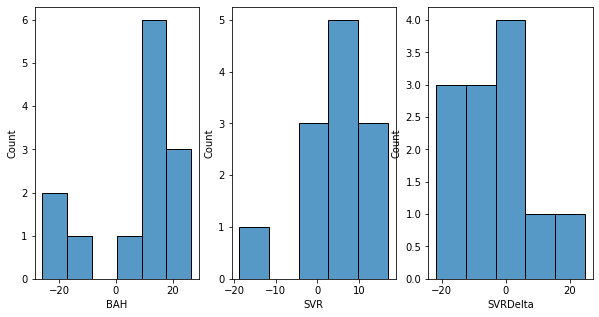

In [16]:
fig, ax =plt.subplots(1,3, figsize = (10,5))
sns.histplot(data = resultsDfAgg['BAH'], ax = ax[0])
sns.histplot(data = resultsDfAgg['SVR'], ax = ax[1])
sns.histplot(data = resultsDfAgg['SVRDelta'], ax = ax[2])

In [17]:
pd.concat([resultsDfAgg[['BAH', 'SVR', 'SVRDelta']].mean(), resultsDfAgg[['BAH', 'SVR', 'SVRDelta']].std()], axis = 1, keys = ['Mean', 'Std'])

,Mean,Std
BAH,6.680000,17.055594
SVR,3.728333,9.129819
SVRDelta,-2.666667,12.717419


### Saving Results

Well, it looks like there's no major difference between the buy-and-hold and SVR strategy - with a mean difference of near 0 and a standard deviation of 3 (which also makes sense eyeballing the distribution) I think its safe to say this isn't a winning approach. Let's save our results and call it a day (for now..)

In [18]:
resultsDfAgg.to_csv(resultsFolder + '/aggDf.csv')